In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
DATA_TRAIN_PATH = '/home/datasets/merc-2017/train/'
DATA_TEST_PATH = '/home/datasets/merc-2017/test/'
LABELS_TRAIN_PATH = '/home/datasets/merc-2017/train/labels/'
LABELS_TEST_PATH = '/home/datasets/merc-2017/test/prediction/'

subfolders = ['audio', 'eyes', 'face_nn', 'kinect']

In [4]:
OBS_WIN = 4
TRAIN_RATIO = 0.8

fpss = {'audio': 100, 'eyes': 50, 'face_nn': 50, 'kinect': 15}
fsizes = {'audio': 36, 'eyes': 6, 'face_nn': 100, 'kinect': 27}

## Train + Val

**Считываем данные:**

In [5]:
dfs_train = {}
for modality in subfolders:
    dfs_train[modality] = {}

for modality in subfolders[:]:
    f_videos = sorted(glob(os.path.join(DATA_TRAIN_PATH, modality, '*.csv')))
    for f in log_progress(f_videos):
        if os.path.basename(f) == 'ida29608d8.csv' and modality == 'eyes':
            print 'happend'
            continue
        if modality in ['audio', 'kinect']:
            tmp_df = pd.read_csv(f)
            tmp_df.columns = ['t'] + tmp_df.columns[1:].tolist()
#             print tmp_df.head()
        if modality in ['eyes', 'face_nn']:
            tmp_df = pd.read_csv(f, skiprows=1)
            tmp_df.columns = ['t'] + ['f_' + str(i + 1) for i in range(len(tmp_df.columns) - 1)]
#             print tmp_df.head()

        dfs_train[modality][os.path.basename(f)] = tmp_df
            
#         break
#     break

VBox(children=(HTML(value=u''), IntProgress(value=0, max=272)))

VBox(children=(HTML(value=u''), IntProgress(value=0, max=306)))

happend


VBox(children=(HTML(value=u''), IntProgress(value=0, max=256)))

VBox(children=(HTML(value=u''), IntProgress(value=0, max=295)))

In [6]:
counter = 0

for k, df in dfs_train['eyes'].iteritems():
    tmp = df.drop('t', axis=1).as_matrix()
    if tmp[np.isnan(tmp)].size > 0:
        print k
#         print df.head()
        counter += 1
#         break

print counter

0


**Парсим на временные метки и сами признаки:**

In [7]:
timings_train = {}
data_ts_train = {}
for modality in subfolders:
    data_ts_train[modality] = {}

for modality in log_progress(subfolders[:]):
    
    for f, df in dfs_train[modality].iteritems():
        
        if timings_train.get(f, None) is None:
            timings_train[f] = {}
        timings_train[f][modality] = df.t.as_matrix()
        data_ts_train[modality][f] = df.drop('t', axis=1).as_matrix()
        
#         break
#     break

VBox(children=(HTML(value=u''), IntProgress(value=0, max=4)))

In [8]:
f_videos_train = []

for v in data_ts_train.values():
    f_videos_train += v.keys()
    
f_videos_train = set(f_videos_train)
print len(f_videos_train)

306


**Наконец идем временным окном по всем видео по всем модальностям и собираем X:**

In [9]:
X_all = []

for f in log_progress(f_videos_train):
    df_labels = pd.read_csv(os.path.join(LABELS_TRAIN_PATH, f))
    
    # Эмпирически?
#     t_start = round(np.min(np.concatenate(timings[f].values())), 3)
#     t_end = round(np.max(np.concatenate(timings[f].values())), 3)

    # Теоретически?
    t_start = df_labels.Time.min()
    t_end = df_labels.Time.max()
    
    tmp_storage = {}
    for modality in subfolders[:]:
        feats = data_ts_train[modality].get(f, None)
        
        tmp_x = []
        for i in range(int((t_end - t_start - OBS_WIN + 1))):
            
            # Вообще нет видео для модальности!
            if feats is None:
                data = np.asarray( [ [-1] * fsizes[modality] ] * fpss[modality] * OBS_WIN )
                
                tmp_x.append(data)
#                 break
            else:  
                tmp_start = t_start + i
                tmp_end = t_start + i + OBS_WIN
                
                data = feats[(timings_train[f][modality] >= tmp_start) & (timings_train[f][modality] < tmp_end)]
                ts_real = timings_train[f][modality][(timings_train[f][modality] >= tmp_start) & (timings_train[f][modality] < tmp_end)]
                
                # Видео есть, но запись этой модальности уже закончилась
                if len(ts_real) == 0:
                    data = np.asarray( [ [-1] * fsizes[modality] ] * fpss[modality] * OBS_WIN )
                    
                    tmp_x.append(data)
                    continue
                
                ts_target = np.linspace(tmp_start, tmp_end, fpss[modality] * OBS_WIN, endpoint=False)
                
                inds = []
                for val in ts_target:
                    inds.append(np.argmin(np.abs(ts_real - val)))
                data = data[inds]

                tmp_x.append(data)
#                 break

        tmp_storage[modality] = np.asarray(tmp_x)   
#         break

    X_all.append(tmp_storage)
#     break

VBox(children=(HTML(value=u''), IntProgress(value=0, max=306)))

**То же самое для меток:**

In [10]:
y_all = []; score_all = []

for f in log_progress(f_videos_train):
    df_labels = pd.read_csv(os.path.join(LABELS_TRAIN_PATH, f))
    
    # Эмпирически?
#     t_start = round(np.min(np.concatenate(timings[f].values())), 3)
#     t_end = round(np.max(np.concatenate(timings[f].values())), 3)

    # Теоретически?
    t_start = df_labels.Time.min()
    t_end = df_labels.Time.max()
        
    tmp_y = []
    for i in range(int((t_end - t_start - OBS_WIN + 1))):
        
        tmp_start = t_start + i
        tmp_end = t_start + i + OBS_WIN

        labels = df_labels[(df_labels.Time >= tmp_start) & (df_labels.Time < tmp_end)][df_labels.columns[1:-1]].as_matrix()
        scores = df_labels[(df_labels.Time >= tmp_start) & (df_labels.Time < tmp_end)]['Agreement score'].as_matrix()
        
        labels_w = np.multiply(labels.T, scores.T).T
        lbl = np.argmax(np.sum(labels_w, axis=0))
        tmp_y.append(lbl)

#         break

    y_all.append(np.asarray(tmp_y, dtype=np.uint8))
    
#     break

VBox(children=(HTML(value=u''), IntProgress(value=0, max=306)))

### Checks

In [11]:
for i, vals in enumerate(zip(X_all, y_all)):
    x, y = vals
    if x['audio'].shape[0] != y.shape[0]:
        print '{}: {} vs {}'.format(i, x['audio'].shape[0], y.shape[0])

In [12]:
for i, vals in enumerate(zip(X_all, y_all)):
    x, y = vals
    if x['eyes'].shape[0] != y.shape[0]:
        print '{}: {} vs {}'.format(i, x['eyes'].shape[0], y.shape[0])

In [13]:
for i, vals in enumerate(zip(X_all, y_all)):
    x, y = vals
    if x['face_nn'].shape[0] != y.shape[0]:
        print '{}: {} vs {}'.format(i, x['face_nn'].shape[0], y.shape[0])

In [14]:
for i, vals in enumerate(zip(X_all, y_all)):
    x, y = vals
    if x['kinect'].shape[0] != y.shape[0]:
        print '{}: {} vs {}'.format(i, x['kinect'].shape[0], y.shape[0])

In [15]:
counter = 0

for i, el in enumerate(X_all):
    if el['audio'].shape[0] == el['eyes'].shape[0] == el['face_nn'].shape[0] == el['kinect'].shape[0]:
        pass
    else:
        print '{}: '.format(i), el['audio'].shape[0], el['eyes'].shape[0], el['face_nn'].shape[0], el['kinect'].shape[0]
        counter += 1
        
print '------------'
print counter

------------
0


In [16]:
np.save('tmp_X', X_all)

---

In [18]:
mins, maxs = [], []

tmp = np.concatenate([x['audio'] for x in X_all])
for i in range(tmp.shape[-1]):
    mins.append(tmp[:, :, i].min())
    maxs.append((tmp[:, :, i] - tmp[:, :, i].min()).max())

np.save('audio_mins', mins)
np.save('audio_maxs', maxs)

In [19]:
mins, maxs = [], []

tmp = np.concatenate([x['kinect'] for x in X_all])
for i in range(tmp.shape[-1]):
    mins.append(tmp[:, :, i].min())
    maxs.append((tmp[:, :, i] - tmp[:, :, i].min()).max())

np.save('kinect_mins', mins)
np.save('kinect_maxs', maxs)

In [20]:
del tmp

In [21]:
inds = np.arange(len(y_all))
np.random.seed(42)
np.random.shuffle(inds)

X_train_all, y_train_all = [], []
X_val_all, y_val_all = [], []

for i in inds[: int(TRAIN_RATIO * len(inds))]:
    X_train_all.append(X_all[i])
    y_train_all.append(y_all[i])
    
for i in inds[int(TRAIN_RATIO * len(inds)) :]:
    X_val_all.append(X_all[i])
    y_val_all.append(y_all[i])

print len(X_train_all), len(y_train_all)
print len(X_val_all), len(y_val_all)

244 244
62 62


In [22]:
np.save('X_train_all', X_train_all)
np.save('X_val_all', X_val_all)
np.save('y_train_all', y_train_all)
np.save('y_val_all', y_val_all)

**by modalities:**

In [23]:
X_train_audio = np.concatenate([x['audio'] for x in X_train_all])
X_val_audio = np.concatenate([x['audio'] for x in X_val_all])

print X_train_audio.shape, X_val_audio.shape

np.save('X_train_audio', X_train_audio)
np.save('X_val_audio', X_val_audio)

(8332, 400, 36) (2114, 400, 36)


In [24]:
X_train_eyes = np.concatenate([x['eyes'] for x in X_train_all])
X_val_eyes = np.concatenate([x['eyes'] for x in X_val_all])

print X_train_eyes.shape, X_val_eyes.shape

np.save('X_train_eyes', X_train_eyes)
np.save('X_val_eyes', X_val_eyes)

(8332, 200, 6) (2114, 200, 6)


In [25]:
X_train_face = np.concatenate([x['face_nn'] for x in X_train_all])
X_val_face = np.concatenate([x['face_nn'] for x in X_val_all])

print X_train_face.shape, X_val_face.shape

np.save('X_train_face', X_train_face)
np.save('X_val_face', X_val_face)

(8332, 200, 100) (2114, 200, 100)


In [26]:
X_train_kinect = np.concatenate([x['kinect'] for x in X_train_all])
X_val_kinect = np.concatenate([x['kinect'] for x in X_val_all])

print X_train_kinect.shape, X_val_kinect.shape

np.save('X_train_kinect', X_train_kinect)
np.save('X_val_kinect', X_val_kinect)

(8332, 60, 27) (2114, 60, 27)


In [27]:
y_train = np.concatenate(y_train_all)
y_val = np.concatenate(y_val_all)

print y_train.shape, y_val.shape

np.save('y_train', y_train)
np.save('y_val', y_val)

(8332,) (2114,)


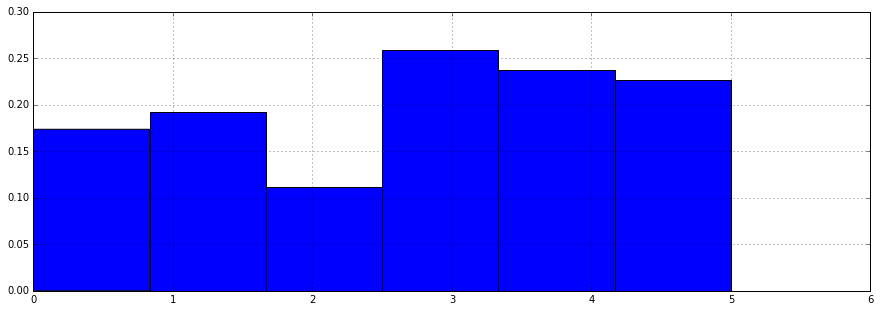

In [28]:
plt.figure(figsize=(15, 5))

plt.hist(np.concatenate(y_train_all), bins=6, normed=True)
plt.grid(True)

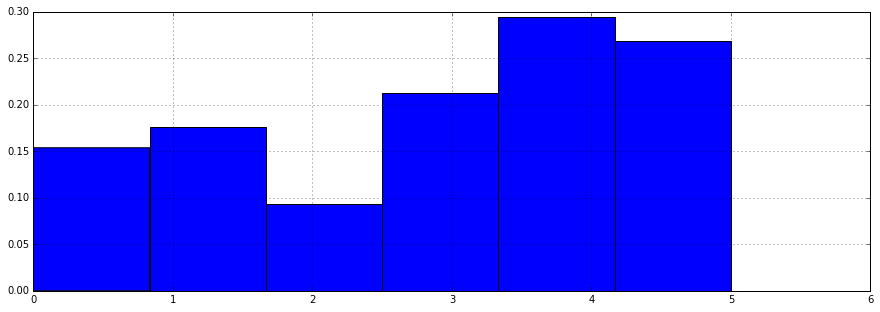

In [29]:
plt.figure(figsize=(15, 5))

plt.hist(np.concatenate(y_val_all), bins=6, normed=True)
plt.grid(True)

## Test

**Считываем данные:**

In [5]:
dfs_test = {}
for modality in subfolders:
    dfs_test[modality] = {}

for modality in subfolders[:]:
    f_videos = sorted(glob(os.path.join(DATA_TEST_PATH, modality, '*.csv')))
    for f in log_progress(f_videos):
        if modality in ['audio', 'kinect']:
            tmp_df = pd.read_csv(f)
            tmp_df.columns = ['t'] + tmp_df.columns[1:].tolist()
#             print tmp_df.head()
        if modality in ['eyes', 'face_nn']:
            tmp_df = pd.read_csv(f, skiprows=1)
            tmp_df.columns = ['t'] + ['f_' + str(i + 1) for i in range(len(tmp_df.columns) - 1)]
#             print tmp_df.head()

        dfs_test[modality][os.path.basename(f)] = tmp_df
            
#         break
#     break

VBox(children=(HTML(value=u''), IntProgress(value=0, max=122)))

VBox(children=(HTML(value=u''), IntProgress(value=0, max=141)))

VBox(children=(HTML(value=u''), IntProgress(value=0, max=124)))

VBox(children=(HTML(value=u''), IntProgress(value=0, max=136)))

**Парсим на временные метки и сами признаки:**

In [6]:
timings_test = {}
data_ts_test = {}
for modality in subfolders:
    data_ts_test[modality] = {}

for modality in log_progress(subfolders[:]):
    
    for f, df in dfs_test[modality].iteritems():
        
        if timings_test.get(f, None) is None:
            timings_test[f] = {}
        timings_test[f][modality] = df.t.as_matrix()
        data_ts_test[modality][f] = df.drop('t', axis=1).as_matrix()
        
#         break
#     break

VBox(children=(HTML(value=u''), IntProgress(value=0, max=4)))

In [7]:
f_videos_test = []

for v in data_ts_test.values():
    f_videos_test += v.keys()
    
f_videos_test = set(f_videos_test)
print len(f_videos_test)

141


**Собираем датасет:**

In [8]:
for f in log_progress(f_videos_test):
    df_labels = pd.read_csv(os.path.join(LABELS_TEST_PATH, f))
    
    # Эмпирически?
#     t_start = round(np.min(np.concatenate(timings[f].values())), 3)
#     t_end = round(np.max(np.concatenate(timings[f].values())), 3)

    # Теоретически?
    t_start = df_labels.Time.min()
    t_end = df_labels.Time.max()
#     print f, t_start, t_end
    
    tmp_storage = {}
    for modality in subfolders[:]:
        feats = data_ts_test[modality].get(f, None)
        
        tmp_x = []
        for i in range(int(round((t_end - t_start - OBS_WIN) / 0.01)) + 1):
            
            # Вообще нет видео для модальности!
            if feats is None:
                data = np.asarray( [ [-1] * fsizes[modality] ] * fpss[modality] * OBS_WIN )
                
                tmp_x.append(data)
#                 break
            else:  
                tmp_start = t_start + i * 0.01
                tmp_end = t_start + i * 0.01 + OBS_WIN
                
                data = feats[(timings_test[f][modality] >= tmp_start) & (timings_test[f][modality] <= tmp_end)]
                ts_real = timings_test[f][modality][(timings_test[f][modality] >= tmp_start) & (timings_test[f][modality] <= tmp_end)]
                
                # Видео есть, но запись этой модальности уже закончилась
                if len(ts_real) == 0:
                    data = np.asarray( [ [-1] * fsizes[modality] ] * fpss[modality] * OBS_WIN )
                    
                    tmp_x.append(data)
                    continue
                
                ts_target = np.linspace(tmp_start, tmp_end, fpss[modality] * OBS_WIN, endpoint=False)
                
                inds = []
                for val in ts_target:
                    inds.append(np.argmin(np.abs(ts_real - val)))
                data = data[inds]

                tmp_x.append(data)
#                 break

        tmp_storage[modality] = np.asarray(tmp_x)   
#         break

    np.save('X_test/{}'.format(f.split('.csv')[0]), tmp_storage)
#     break

VBox(children=(HTML(value=u''), IntProgress(value=0, max=141)))

In [9]:
X_test_tinds = {}

for f in log_progress(f_videos_test):
    df_labels = pd.read_csv(os.path.join(LABELS_TEST_PATH, f))
    
    # Эмпирически?
#     t_start = round(np.min(np.concatenate(timings[f].values())), 3)
#     t_end = round(np.max(np.concatenate(timings[f].values())), 3)

    # Теоретически?
    t_start = df_labels.Time.min()
    t_end = df_labels.Time.max()
#     print f, t_start, t_end

    X_test_tinds[f] = []
    for i in range(int(round((t_end - t_start - OBS_WIN) / 0.01)) + 1):

        tmp_start = t_start + i * 0.01
        tmp_end = t_start + i * 0.01 + OBS_WIN

        X_test_tinds[f].append([tmp_start, tmp_end])

#     break

VBox(children=(HTML(value=u''), IntProgress(value=0, max=141)))

In [11]:
np.save('X_test_tinds', X_test_tinds)